In [2]:
# Import libraries and functions first
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import punkt
from collections import Counter
from string import punctuation

In [45]:
# Read in businesses and AZ reviews data from kaggle
yelp_review = pd.read_csv('yelp_review_arizona.csv')
yelp_bus = pd.read_csv('yelp_business.csv')
yelp_bus = yelp_bus.dropna(subset=['attributes'])

,user_id,business_id,tip,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0
...,...,...,...,...,...
908910,eYodOTF8pkqKPzHkcxZs-Q,3lHTewuKFt5IImbXJoFeDQ,Disappointed in one of your managers.,2021-09-11 19:18:57,0
908911,1uxtQAuJ2T5Xwa_wp7kUnA,OaGf0Dp56ARhQwIDT90w_g,Great food and service.,2021-10-30 11:54:36,0
908912,v48Spe6WEpqehsF2xQADpg,hYnMeAO77RGyTtIzUSKYzQ,Love their Cubans!!,2021-11-05 13:18:56,0
908913,ckqKGM2hl7I9Chp5IpAhkw,s2eyoTuJrcP7I_XyjdhUHQ,Great pizza great price,2021-11-20 16:11:44,0


True

In [65]:
# Concatenate datasets for one larger one
df_yelp = yelp_bus.merge(yelp_review, on='business_id')
df_yelp.to_csv('df_yelp.csv')

In [57]:
# Process attributes so they are meaningful
# Create function to convert the attribute column with an indicator so the dictionary can be searched to identify attributes
def attribute_format(row):
    # Initialize empty dictionary
    attribute_dict = {}
    
    # Iterate through each cell (containing attribute att and indicator ind) in attribute column
    for att, ind in row.items():
        # Convert to lowercase and check if the value of the indicator is true or false 
        if ind in [True, False]:
            # If indicator is true, put true in corresponding dictionary index, if not then false
            attribute_dict[att] = (ind == True)
        # Otherwise, just add the value to the dictionary
        else:  
            attribute_dict[att] = ind
    # Return the dictionary of business attributes for the given row
    return attribute_dict          

In [58]:
# Tokenize review text for proper analysis
# Create function to process
def preprocess_reviews(text):
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove punctuation besides '!'
    tokens = [token for token in tokens if token not in punctuation or token == '!']
    
    # Remove stop words from reviews
    stop_wrds = set(stopwords.words('english'))
    # Ensure to convert to lowercase when checking as it's case sensitive
    tokens = [token for token in tokens if token.lower() not in stop_wrds]
    
    # Return list of tokens in corresponding cells
    return tokens

In [59]:
# Create copy of df to edit
df_yelp_v2 = df_yelp.copy()

# Convert attribute strings to dictionaries and text to strings
df_yelp_v2.loc[:,'attributes'] = df_yelp_v2.loc[:,'attributes'].apply(eval)
df_yelp_v2.loc[:,'text'] = df_yelp_v2.loc[:,'text'].astype(str)

# Apply functiions to format the attributes and review text
df_yelp_v2.loc[:,'attributes'] = df_yelp_v2.loc[:,'attributes'].apply(attribute_format)
df_yelp_v2.loc[:,'text'] = df_yelp_v2.loc[:,'text'].apply(preprocess_reviews)

In [60]:
# Take a peek at the dataset!
display(df_yelp_v2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,is_open,attributes,categories,hours,review_id,user_id,text,stars_y,date
0,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,"13843 N Tatum Blvd, Ste 15",Phoenix,AZ,85032,33.613020,-111.977036,3.5,269,1,"{'Caters': 'True', 'GoodForKids': 'True', 'Noi...","Chinese, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",rpeYoDzPffuEhhhTRV3S-g,77ykjIShGYAQvoTYYM7GWA,"[reading, many, decent, reviews, seeing, close...",2.0,2011-10-30 03:52:38
1,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,"13843 N Tatum Blvd, Ste 15",Phoenix,AZ,85032,33.613020,-111.977036,3.5,269,1,"{'Caters': 'True', 'GoodForKids': 'True', 'Noi...","Chinese, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",h9GPZNKBkcuK5Ge0NAce1w,xovKY9oB8s-NjKz_I1RpHQ,"[recent, lunch, Nee, House, changed, whole, op...",4.0,2010-08-27 05:59:51
2,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,"13843 N Tatum Blvd, Ste 15",Phoenix,AZ,85032,33.613020,-111.977036,3.5,269,1,"{'Caters': 'True', 'GoodForKids': 'True', 'Noi...","Chinese, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",kpHVcfqDakiWrcqJYAs2zg,Gfxb_D1k8tueAoGn4cseoA,"['ve, coming, last, fifteen, years, since, use...",4.0,2015-04-16 22:51:03
3,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,"13843 N Tatum Blvd, Ste 15",Phoenix,AZ,85032,33.613020,-111.977036,3.5,269,1,"{'Caters': 'True', 'GoodForKids': 'True', 'Noi...","Chinese, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",514znlsbSlpmvXtHXOjxHQ,y9yLaWKlT2aXLBs50FGvaw,"[enjoyed, lunch, Nee, House, today, restaurant...",4.0,2015-02-06 07:47:46
4,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,"13843 N Tatum Blvd, Ste 15",Phoenix,AZ,85032,33.613020,-111.977036,3.5,269,1,"{'Caters': 'True', 'GoodForKids': 'True', 'Noi...","Chinese, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",Tr4Fiufa6bFNmMeMEm4osQ,98n8K9brl0Dc8TocyuD1bw,"[great, place, get, ordinary, Chinese, food, p...",4.0,2012-02-09 02:16:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26601,aw0H9O1yysoHB0JanT0Ubw,Chicago Gyros,"717 W Union Hills Dr, Ste 1",Phoenix,AZ,85027,33.654353,-112.083580,4.0,275,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Restaurants, Greek, Mediterranean","{'Monday': '0:0-0:0', 'Tuesday': '11:0-20:0', ...",tfMjRNHwsNvzEkg9xG-CBA,6fjsqDqQU6-Jsue9Gd9YTg,"[First, thing, say, place, hard, us, nocturnal...",4.0,2010-06-18 23:08:27
26602,aw0H9O1yysoHB0JanT0Ubw,Chicago Gyros,"717 W Union Hills Dr, Ste 1",Phoenix,AZ,85027,33.654353,-112.083580,4.0,275,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Restaurants, Greek, Mediterranean","{'Monday': '0:0-0:0', 'Tuesday': '11:0-20:0', ...",4RcsWd-UMk1I1bcX3gipLw,SaL1BUnJes5SCmqm5rufdQ,"[God, love, place, craving, place, addicted, c...",5.0,2011-11-12 01:06:39
26603,aw0H9O1yysoHB0JanT0Ubw,Chicago Gyros,"717 W Union Hills Dr, Ste 1",Phoenix,AZ,85027,33.654353,-112.083580,4.0,275,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Restaurants, Greek, Mediterranean","{'Monday': '0:0-0:0', 'Tuesday': '11:0-20:0', ...",SfXqwoFIoM0tGldflR5ivQ,oWd7wL340Z9JiGf5Wu_bSQ,"[Nice, little, place, 'm, big, gyro, fan, wife...",4.0,2010-08-04 18:45:05
26604,aw0H9O1yysoHB0JanT0Ubw,Chicago Gyros,"717 W Union Hills Dr, Ste 1",Phoenix,AZ,85027,33.654353,-112.083580,4.0,275,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Restaurants, Greek, Mediterranean","{'Monday': '0:0-0:0', 'Tuesday': '11:0-20:0', ...",zkPVP8PjZlZKALIUugaE3g,1i3WvtGsIW8FGOFLvHHFMw,"['ve, ordering, delivery, place, several, time...",5.0,2016-08-23 03:30:10


In [69]:
# Count attribute frequencies across the entire dataset and get top 10
all_attributes = [attr for attrs in df_yelp_v2['attributes'] for attr in attrs]
top_10_att = [attr for attr, _ in Counter(all_attributes).most_common(10)]
display(top_10_att)
# Modify the 'attributes' column to include only the top 10 attributes
df_yelp_v2['attributes_top_10'] = df_yelp_v2['attributes'].apply(lambda attrs: {attr: value for attr, value in attrs.items() if attr in top_10_att})

['BusinessAcceptsCreditCards',
 'RestaurantsPriceRange2',
 'BusinessParking',
 'BikeParking',
 'RestaurantsTakeOut',
 'WiFi',
 'Caters',
 'OutdoorSeating',
 'Alcohol',
 'HasTV']

In [97]:
# Define reviews and the attributes from the data
reviews = df_yelp_v2['text']
attributes = df_yelp_v2['attributes_top_10']

display(reviews)
display(attributes)

0        [reading, many, decent, reviews, seeing, close...
1        [recent, lunch, Nee, House, changed, whole, op...
2        ['ve, coming, last, fifteen, years, since, use...
3        [enjoyed, lunch, Nee, House, today, restaurant...
4        [great, place, get, ordinary, Chinese, food, p...
                               ...                        
26601    [First, thing, say, place, hard, us, nocturnal...
26602    [God, love, place, craving, place, addicted, c...
26603    [Nice, little, place, 'm, big, gyro, fan, wife...
26604    ['ve, ordering, delivery, place, several, time...
26605    [Yes, place, called, Chicago, GYROS, ..., 'm, ...
Name: text, Length: 26606, dtype: object

0        {'Caters': 'True', 'RestaurantsPriceRange2': '...
1        {'Caters': 'True', 'RestaurantsPriceRange2': '...
2        {'Caters': 'True', 'RestaurantsPriceRange2': '...
3        {'Caters': 'True', 'RestaurantsPriceRange2': '...
4        {'Caters': 'True', 'RestaurantsPriceRange2': '...
                               ...                        
26601    {'Caters': 'True', 'BusinessAcceptsCreditCards...
26602    {'Caters': 'True', 'BusinessAcceptsCreditCards...
26603    {'Caters': 'True', 'BusinessAcceptsCreditCards...
26604    {'Caters': 'True', 'BusinessAcceptsCreditCards...
26605    {'Caters': 'True', 'BusinessAcceptsCreditCards...
Name: attributes_top_10, Length: 26606, dtype: object

In [73]:
# Create testing and training sets
train_x, test_x, train_y, test_y = train_test_split(reviews, attributes, test_size=0.2, random_state=25)



In [74]:
# Convert list of tokens to strings
train_x_strings = [' '.join(tokens) for tokens in train_x]
test_x_strings = [' '.join(tokens) for tokens in test_x]  # Ensure test data is preprocessed similarly

# Feature Extraction with TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
train_x_tfidf = tfidf_vectorizer.fit_transform(train_x_strings)
test_x_tfidf = tfidf_vectorizer.transform(test_x_strings)  # Use transform for test data

# Preprocessing for train_y 
mlb = MultiLabelBinarizer()
y_binary_train = mlb.fit_transform([list(y.keys()) for y in train_y])

# Training Random Forest classifier
classifier = RandomForestClassifier(n_estimators=200, random_state=25)
classifier.fit(train_x_tfidf, y_binary_train)

# Predict on test_x_tfidf
predicted_attributes = classifier.predict(test_x_tfidf)

# Convert the actual test_y to binary format using MultiLabelBinarizer fitted on train_y
y_binary_test = mlb.transform([list(y.keys()) for y in test_y])

# Calculate accuracy
accuracy = accuracy_score(y_binary_test, predicted_attributes)
print("Random Forest Accuracy:", accuracy)

Random Forest Accuracy: 0.9430665163472379


In [94]:
# Determine labels so confusion matrix results are more interpretable
# What's popular?
pop_attributes = set(label for labels in mlb.inverse_transform(y_binary_test) for label in labels)
print(pop_attributes)


{'RestaurantsTakeOut', 'BusinessAcceptsCreditCards', 'BikeParking', 'RestaurantsPriceRange2', 'BusinessParking', 'Alcohol', 'HasTV', 'Caters', 'WiFi', 'OutdoorSeating'}


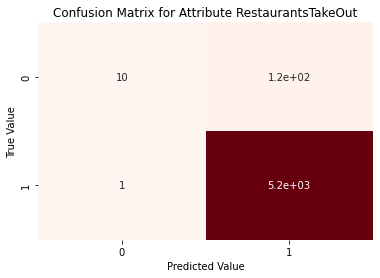

<Figure size 360x360 with 0 Axes>

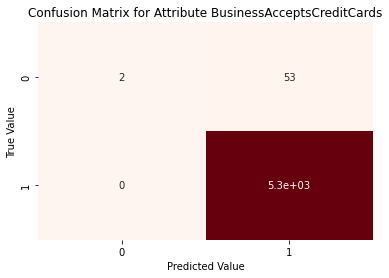

<Figure size 360x360 with 0 Axes>

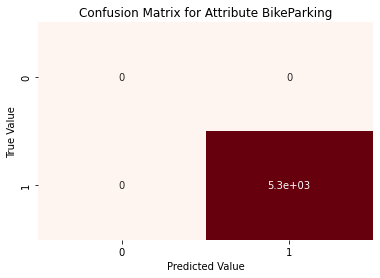

<Figure size 360x360 with 0 Axes>

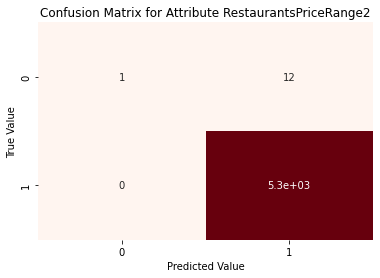

<Figure size 360x360 with 0 Axes>

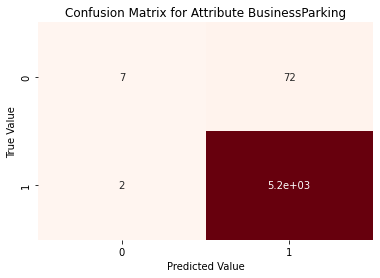

<Figure size 360x360 with 0 Axes>

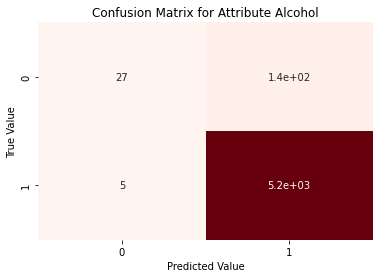

<Figure size 360x360 with 0 Axes>

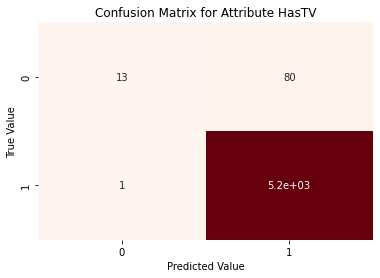

<Figure size 360x360 with 0 Axes>

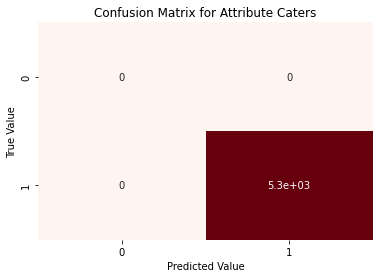

<Figure size 360x360 with 0 Axes>

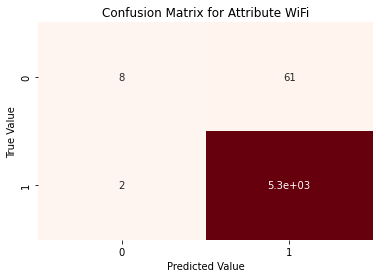

<Figure size 360x360 with 0 Axes>

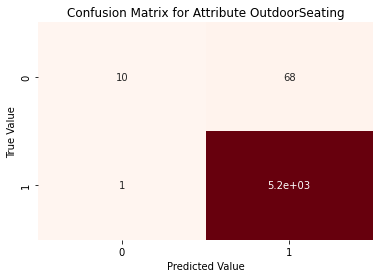

<Figure size 360x360 with 0 Axes>

In [99]:
from sklearn.metrics import multilabel_confusion_matrix

# Build confusion matrix for random forest model
conf_mat = multilabel_confusion_matrix(y_binary_test, predicted_attributes)

# Function to display all matrices for all attributes in top 10
for attr, conf_mat in zip(pop_attributes, conf_mat):
    # Display confusion matrix as heatmap for interpretation
    sns.heatmap(conf_mat, annot=True, cmap='Reds', cbar=False)

    # Axis labels
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')

    # Title label
    plt.title(f'Confusion Matrix for Attribute {attr}') # so we can understand each attribute it's associated with

    # Adjust fig size and display plot
    plt.figure(figsize=(5,5))
    plt.show()